In [1]:
import pandas as pd
import pickle
import datetime as dt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
#from LogIn import LogIn
#kite = LogIn().return_kite_obj()

In [3]:
budget_df = pd.read_csv('budget.csv')

In [4]:
budget_df

,instrument,budget,return
0,NSE:UNIONBANK,400,0.02
1,NSE:DCBBANK,400,0.02
2,NSE:YESBANK,400,0.02
3,NSE:WIPRO,400,0.02
4,NSE:TATASTEEL,400,0.02
5,NSE:SBIN,400,0.02
6,NSE:PNB,400,0.02
7,NSE:ONGC,400,0.02
8,NSE:OIL,400,0.02
9,NSE:NTPC,400,0.02


# Inputs

In [5]:
from_date = '2017-01-01'
to_date = '2017-12-31'

In [6]:
leverage = 15
exit_time = dt.time(15, 10)

# Process

In [7]:
# Download data of all companies
download = False

if download:
    for instrument in budget_df.instrument.tolist():

        try:
            print('------------')
            print(instrument)
            instrument_token = kite.ohlc(instrument)[instrument]['instrument_token']
            data = kite.historical_data(instrument_token=instrument_token, from_date=from_date, to_date=to_date, interval='minute', continuous=False)
            data_df = pd.DataFrame(data)
            data_df.to_pickle('./data/{}_{}_{}.pkl'.format(instrument, from_date, to_date))

        except Exception as ex:
            print('Failed for {} : {}'.format(instrument, ex))

In [8]:
def get_clean_data(instrument, from_date, to_date):
    
    print(instrument)
    data_df = pd.read_pickle('./data/{}_{}_{}.pkl'.format(instrument, from_date, to_date))
    data_df.rename(columns={'date':'timestamp'}, inplace=True)
    data_df['date'] = data_df['timestamp'].dt.date
    data_df['day'] = data_df['timestamp'].dt.day_name()
    print(len(data_df))

    sanity_check = data_df.groupby('date').count().reset_index()
    incomplete_data_days = sanity_check[sanity_check['volume']<300]
    print(incomplete_data_days)

    data_df = data_df[~data_df['date'].isin(incomplete_data_days.date.tolist())]
    data_df['instrument'] = instrument
    print(len(data_df)/375)
    
    return data_df

In [9]:
header_list = ['instrument', 'high_prev', 'low_prev', 'open_today', 'condition', 'transaction_type', 'trade_number', 'level', 'budget', 'return', 'daily_khwab', 'actual_khwab', 'quantity', 'budget_required', 'price', 'trigger_price', 'squareoff', 'stoploss', 'order_id', 'timestamp', 'order_type', 'status', 'profit', 'pl_tag', 'flag', 'adhoora_khwab']


In [10]:
calculate = True

if calculate:
    
    all_trades = pd.DataFrame(columns=header_list)

    for instrument in budget_df.instrument.tolist():

        try:
            data_df = get_clean_data(instrument, from_date, to_date)

            for i in range(len(data_df.date.unique().tolist())-1):

                date_prev = data_df.date.unique().tolist()[i]
                data_prev = data_df[data_df['date']==date_prev]
                open_prev = data_prev.open.iloc[0]
                close_prev = data_prev.open.iloc[-1]
                high_prev = data_prev.high.max()
                low_prev = data_prev.low.min()

                date_today = data_df.date.unique().tolist()[i+1]
                data_today = data_df[data_df['date']==date_today]

                # Trim beyond exit time
                data_today = data_today[data_today['timestamp'].dt.time<exit_time]
                open_today = data_today.open.iloc[0]

                if (open_today > high_prev) & (open_today < 1.15 * high_prev):

                    condition = 'high'
                    transaction_type = 'buy'

                elif (open_today < low_prev) & (open_today > 0.85 * low_prev):

                    condition = 'low'
                    transaction_type = 'sell'

                else:

                    condition = None
                    transaction_type = None

                if condition is not None:

                    valid_trades = all_trades[(all_trades['instrument']==instrument) & (all_trades['condition']==condition) & (all_trades['status']=='complete')]
                    last_valid_trade = valid_trades[valid_trades['trade_number']==valid_trades['trade_number'].max()]
                    
                    # Calculate trade number
                    if len(last_valid_trade):
                        trade_number = int(last_valid_trade['trade_number']) + 1
                    else:
                        trade_number = 1

                    # Calculate level
                    if len(last_valid_trade):
                        if float(last_valid_trade['pl_tag'])==1.0:
                            level = 1
                        else:
                            level = float(last_valid_trade['level']) + 1
                    else:
                        level = 1

                    # Calculate budget and return
                    if level==1:
                        budget = float(budget_df[budget_df['instrument']==instrument]['budget'])
                        return_ = float(budget_df[budget_df['instrument']==instrument]['return'])
                    else:
                        budget = float(last_valid_trade['budget'])
                        return_ = float(last_valid_trade['return'])

                    # Calculate daily khwab
                    if len(last_valid_trade):
                        if (int(last_valid_trade['flag'])==1) | (int(last_valid_trade['flag'])==2)| (int(last_valid_trade['flag'])==4) | (float(last_valid_trade['profit']) >= round(return_ * budget, 2)):
                            daily_khwab = round(return_ * budget, 2)
                        else:
                            daily_khwab = 0
                    else:
                        daily_khwab = round(return_ * budget, 2)

                    # Calculate actual khwab
                    if len(last_valid_trade):
                        actual_khwab = max(round(float(last_valid_trade['adhoora_khwab']) + daily_khwab, 2), round(return_ * budget, 2))
                    else:
                        actual_khwab = round(return_ * budget, 2)

                    # Calculate quantity
                    quantity = int(round(actual_khwab/(return_ * open_today)))
                    quantity_1 = round(quantity//2)
                    quantity_2 = round(quantity - quantity_1)
                    
                    # Calculate budget required
                    budget_required = round(quantity * open_today, 2)

                    # Calculate price and trigger price
                    if condition=='high':
                        price = round(open_today + 0.05 * max(round(20 * 0.0010 * open_today), 2), 2)
                        trigger_price = round(open_today + 0.05 * max(round(20 * 0.0005 * open_today),1), 2)
                    else:
                        price = round(open_today - 0.05 * max(round(20 * 0.0010 * open_today), 2), 2)
                        trigger_price = round(open_today - 0.05 * max(round(20 * 0.0005 * open_today),1), 2)

                    # Calculate square off and stoploss
                    squareoff = round(return_ * price, 1)
                    stoploss = round(return_ * price, 1)

                    # Calculate order_id, order_type
                    order_id = trade_number
                    order_type = 'SL'

                    # Calculate timestamp, status, profit, flag
                    if transaction_type=='buy':

                        if data_today.high.max() < trigger_price:

                            timestamp = data_today.timestamp.iloc[0]
                            status = 'incomplete'
                            profit = 0
                            flag = 0

                        else:

                            status = 'complete'
                            for index, row in data_today.iterrows():

                                if row['high'] > price + 0.5 * squareoff:
                                    profit_1 = round(0.5 * squareoff * quantity_1, 2)
                                    flag_1 = 1
                                    break

                                elif row['low'] < price - stoploss:
                                    profit_1 = round(-1 * stoploss * quantity_1, 2)
                                    flag_1 = 2
                                    break

                                else:
                                    profit_1 = round((row['close']-price) * quantity_1, 2)
                                    flag_1 = 3
                                    
                            for index, row in data_today.iterrows():

                                if row['high'] > price + squareoff:
                                    timestamp = row['timestamp']
                                    profit_2 = round(squareoff * quantity_2, 2)
                                    flag_2 = 1
                                    break

                                elif row['low'] < price - stoploss:
                                    timestamp = row['timestamp']
                                    profit_2 = round(-1 * stoploss * quantity_2, 2)
                                    flag_2 = 2
                                    break

                                else:
                                    timestamp = row['timestamp']
                                    profit_2 = round((row['close']-price) * quantity_2, 2)
                                    flag_2 = 3
                                    
                            profit = profit_1 + profit_2
                            
                            if flag_1==1:
                                if flag_2==1:
                                    flag = 1
                                elif flag_2==2:
                                    flag = 2
                                else:
                                    flag = 3
                            elif flag_1==2:
                                flag = 4
                            else:
                                flag = 5

                    else:

                        if data_today.low.min() > trigger_price:
                            timestamp = data_today.timestamp.iloc[0]
                            status = 'incomplete'
                            profit = 0
                            flag = 0
                            
                        else:
                            
                            status = 'complete'
                            for index, row in data_today.iterrows():

                                if row['low'] < price - 0.5 * squareoff:
                                    profit_1 = round(0.5 * squareoff * quantity_1, 2)
                                    flag_1 = 1
                                    break

                                elif row['high'] > price + stoploss:
                                    profit_1 = round(-1 * stoploss * quantity_1, 2)
                                    flag_1 = 2
                                    break

                                else:
                                    profit_1 = round((price - row['close']) * quantity_1, 2)
                                    flag_1 = 3
                                    
                            for index, row in data_today.iterrows():

                                if row['low'] < price - squareoff:
                                    timestamp = row['timestamp']
                                    profit_2 = round(squareoff * quantity_2, 2)
                                    flag_2 = 1
                                    break

                                elif row['high'] > price + stoploss:
                                    timestamp = row['timestamp']
                                    profit_2 = round(-1 * stoploss * quantity_2, 2)
                                    flag_2 = 2
                                    break

                                else:
                                    timestamp = row['timestamp']
                                    profit_2 = round((price - row['close']) * quantity_2, 2)
                                    flag_2 = 3
                                    
                            profit = profit_1 + profit_2
                            
                            if flag_1==1:
                                if flag_2==1:
                                    flag = 1
                                elif flag_2==2:
                                    flag = 2
                                else:
                                    flag = 3
                            elif flag_1==2:
                                flag = 4
                            else:
                                flag = 5       
                    
                    # Calculate P/L tag
                    pl_tag = round(round(float(profit), 2) / (float(squareoff) * float(quantity)), 1)
                    
                    # Calculate adhoora khwab
                    adhoora_khwab = round(float(actual_khwab) - profit, 2)

                    trades_today = pd.DataFrame(data={'instrument':[instrument], 
                                                      'high_prev':[high_prev], 
                                                      'low_prev':[low_prev], 
                                                      'open_today':[open_today], 
                                                      'condition':[condition], 
                                                      'transaction_type':[transaction_type], 
                                                      'trade_number':[trade_number], 
                                                      'level':[level], 
                                                      'budget':[budget], 
                                                      'return':[return_], 
                                                      'daily_khwab':[daily_khwab], 
                                                      'actual_khwab':[actual_khwab], 
                                                      'quantity':[quantity], 
                                                      'budget_required':[budget_required], 
                                                      'price':[price], 
                                                      'trigger_price':[trigger_price], 
                                                      'squareoff':[squareoff], 
                                                      'stoploss':[stoploss], 
                                                      'order_id':[order_id], 
                                                      'timestamp':[timestamp], 
                                                      'order_type':[order_type], 
                                                      'status':[status], 
                                                      'profit':[profit], 
                                                      'pl_tag':[pl_tag], 
                                                      'flag':[flag], 
                                                      'adhoora_khwab':[adhoora_khwab]
                                                     })

                    all_trades = all_trades.append(trades_today, ignore_index = True)
        except Exception as ex:
            print('Failed calculation for {} : {}'.format(instrument, ex))
            
    all_trades.to_pickle('all_trades_split_{}_{}.pkl'.format(from_date, to_date))
    
else:
    
    all_trades = pd.read_pickle('all_trades_split_{}_{}.pkl'.format(from_date, to_date))

NSE:UNIONBANK
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:DCBBANK
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:YESBANK
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:WIPRO
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:TATASTEEL
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180  

NSE:L&TFH
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:PFC
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:EQUITAS
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:TATAMOTORS
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:IOC
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  1

In [11]:
#1 : 'pehle_plus_1_phir_plus_2'
#2 : 'pehle_plus_1_phir_minus_2'
#3 : 'pehle_plus_1_phir_exit'
#4 : 'pehle_minus_2'
#5 : 'pehle_exit'

# High Trades Analysis

In [12]:
high_trades = all_trades[(all_trades['condition']=='high') & (all_trades['status']=='complete')]

In [13]:
high_trades.head()

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
1,NSE:UNIONBANK,139.4,137.3,139.70,high,buy,1,1,400.0,0.02,8.0,8.00,3,419.10,139.85,139.75,2.8,2.8,1,2017-01-25 15:09:00+05:30,SL,complete,4.10,0.5,3,3.90
6,NSE:UNIONBANK,156.9,151.2,157.35,high,buy,2,2,400.0,0.02,0.0,8.00,3,472.05,157.50,157.45,3.2,3.2,2,2017-03-17 10:19:00+05:30,SL,complete,-9.60,-1.0,4,17.60
8,NSE:UNIONBANK,150.5,147.1,151.60,high,buy,3,3,400.0,0.02,8.0,25.60,8,1212.80,151.75,151.70,3.0,3.0,3,2017-03-24 12:42:00+05:30,SL,complete,18.00,0.8,1,7.60
10,NSE:UNIONBANK,160.9,156.5,160.95,high,buy,4,4,400.0,0.02,8.0,15.60,5,804.75,161.10,161.05,3.2,3.2,4,2017-04-25 15:09:00+05:30,SL,complete,9.05,0.6,3,6.55
11,NSE:UNIONBANK,192.2,181.0,192.40,high,buy,5,5,400.0,0.02,8.0,14.55,4,769.60,192.60,192.50,3.9,3.9,5,2017-05-05 11:12:00+05:30,SL,complete,11.70,0.8,1,2.85


# Low Trades Analysis

In [14]:
low_trades = all_trades[(all_trades['condition']=='low') & (all_trades['status']=='complete')]

In [15]:
low_trades.head()

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
0,NSE:UNIONBANK,141.05,135.15,134.5,low,sell,1,1,400.0,0.02,8.0,8.00,3,403.5,134.35,134.45,2.7,2.7,1,2017-01-23 09:48:00+05:30,SL,complete,-8.10,-1.0,4,16.10
2,NSE:UNIONBANK,169.65,164.50,163.0,low,sell,2,2,400.0,0.02,8.0,24.10,7,1141.0,162.85,162.90,3.3,3.3,2,2017-02-09 09:15:00+05:30,SL,complete,18.15,0.8,1,5.95
3,NSE:UNIONBANK,144.15,141.10,141.0,low,sell,3,3,400.0,0.02,8.0,13.95,5,705.0,140.85,140.95,2.8,2.8,3,2017-02-20 15:09:00+05:30,SL,complete,-3.75,-0.3,5,17.70
4,NSE:UNIONBANK,148.00,143.90,143.7,low,sell,4,4,400.0,0.02,0.0,17.70,6,862.2,143.55,143.65,2.9,2.9,4,2017-02-27 12:52:00+05:30,SL,complete,-4.35,-0.2,2,22.05
7,NSE:UNIONBANK,158.90,151.80,150.2,low,sell,5,5,400.0,0.02,8.0,30.05,10,1502.0,150.05,150.10,3.0,3.0,5,2017-03-22 15:09:00+05:30,SL,complete,19.00,0.6,3,11.05


# Results

In [16]:
pd.DataFrame(data={'high':[len(high_trades),
                           round(high_trades.profit.sum(), 2), 
                           round(high_trades.profit.sum()/budget_df.budget.sum() * 100, 2),
                           round(high_trades.budget_required.max()), 
                           round(high_trades.budget_required.max()/leverage)],
                   'low':[len(low_trades),
                          round(low_trades.profit.sum(), 2), 
                          round(low_trades.profit.sum()/budget_df.budget.sum() * 100, 2),
                          round(low_trades.budget_required.max()),
                          round(low_trades.budget_required.max()/leverage)]
                   }, 
             index = ['total_trades', 'profit', 'perc_return', 'hightest_budget_required', 'hightest_margin_required'])

,high,low
total_trades,1544.00,716.00
profit,-8306.05,981.34
perc_return,-29.56,3.49
hightest_budget_required,354776.00,38025.00
hightest_margin_required,23652.00,2535.00


# Daily Margin Required Analysis

In [17]:
all_trades['date'] = all_trades['timestamp'].dt.date
all_trades['margin_required'] = all_trades['budget_required']/leverage
margins = all_trades.groupby('date').agg({'budget_required':sum, 'margin_required':sum, 'instrument':list}).reset_index()

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def stacked_bar(data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels, rotation='vertical')

    if y_label:
        plt.ylabel(y_label)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

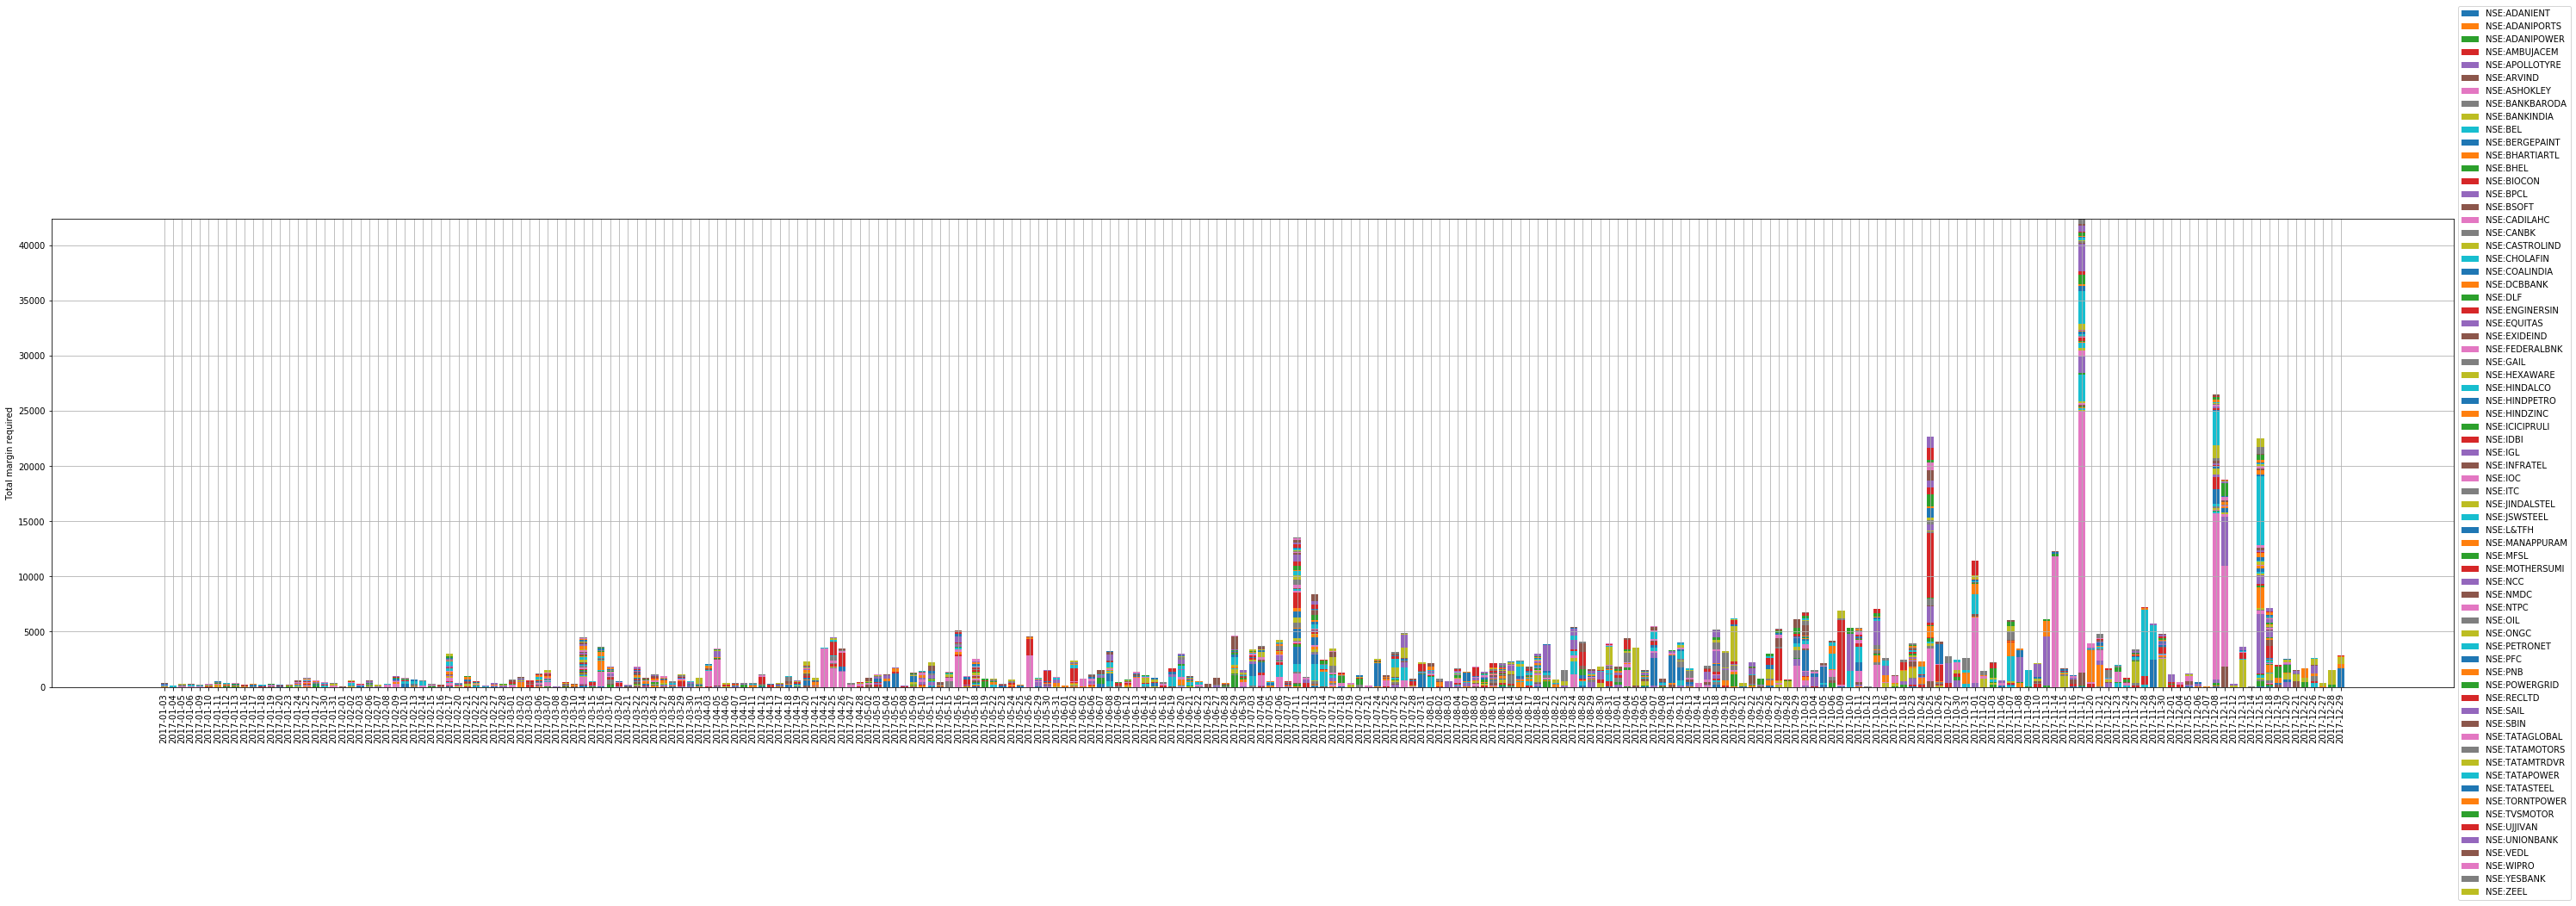

In [19]:
df2 = all_trades.groupby(['date', 'instrument'])['margin_required'].sum().unstack('instrument').fillna(0)

df = df2.transpose()

plt.figure(figsize=(50, 10))

series_labels = df.index.tolist()

data = df.values

category_labels = df.columns.tolist()

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=False,
    value_format="{:.1f}",
    y_label="Total margin required"
)

plt.savefig('margin_required_split_{}_{}.png'.format(from_date, to_date))
plt.show()